# 实验名称：处理宇宙射线
姓名：何雪莹   
班级：22天文    
学号：2112219044

## 一、实验目的： 
    1、学会使用python以及其与天文图像处理相关的包，并尝试性的对天文图像进行处理。
    2、熟悉fits文件的数据组成和读出以及后续处理方法，并运用python对fits文件进行数据处理。
    3、学会观察图像的直方图，明确直方图的作用和意义。
    4、了解天文图像处理的常用方法和技术手段，并在此次实验采用一部分。
    5、观察包含宇宙射线的深空天文图像，对天文图像处理形成初步的理解。

## 二、实验条件：
    1、在MacBook上运行的python语言和与天文图像处理相关的python包
    2、一幅来自哈勃望远镜的深空图像

## 三、实验步骤：
    1、载入图像的fits格式的文件。
    2、画一个图像的直方图，观察一下图像的能量分布，给出一个图像的最佳的显示效果。
    3、根据对直方图的观察研究一下如何获得最优的阈值。
    4、根据阈值，将图像转变为二值图。
    5、在二值图的基础上，对图像进行相关的形态学处理，去除宇宙射线。
    6、将去除宇宙射线后的二值图乘于原图，最后得到经过处理后的图像。

## 1. 读取fits文件

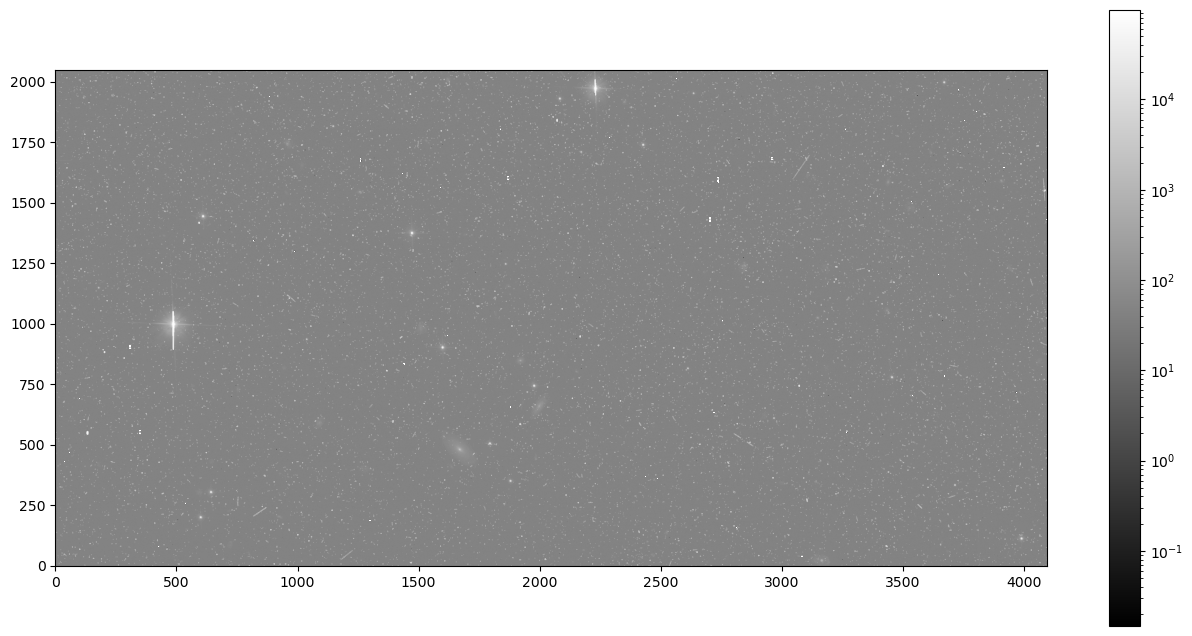

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from astropy.io import fits
from skimage import filters
from skimage import exposure
from matplotlib.colors import LogNorm
import dask
import ccdproc
gals = fits.open('jbit11e1q_flc.fits')
img = gals[1].data 
plt.figure(figsize=(16,8))
plt.imshow(img, cmap='gray', norm=LogNorm(),origin='lower')
plt.colorbar()
plt.show()


## 2. 能量分布直方图

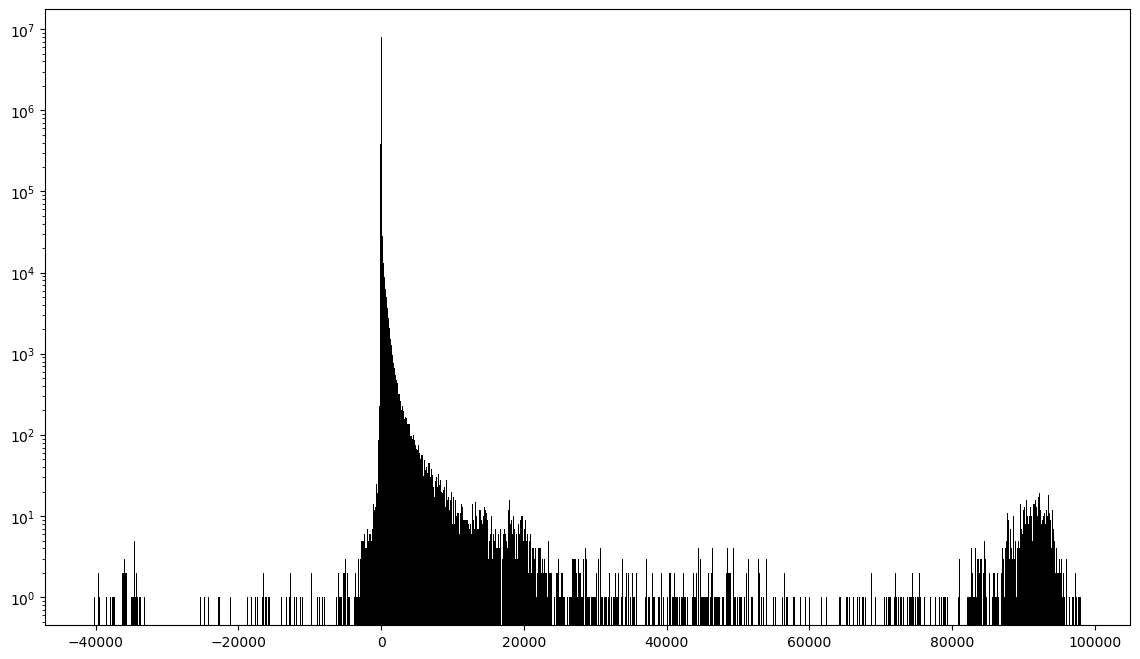

In [2]:
plt.figure(figsize=(14,8))
plt.hist(img.reshape(-1), bins=1000, color='black',log='True')
plt.show()

## 3.1 中值滤波1

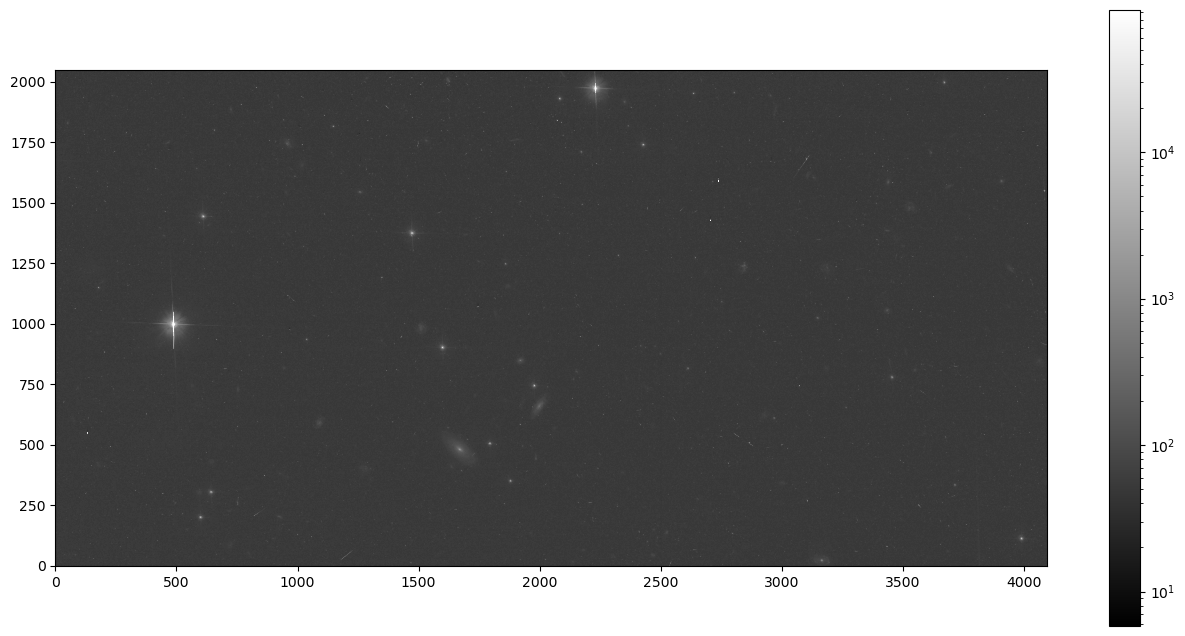

In [3]:
plt.figure(figsize=(16,8))
med3_img = ccdproc.median_filter(img, 3)
med4_img = ccdproc.median_filter(img, 4)
med5_img = ccdproc.median_filter(img, 5)

plt.imshow(med5_img, origin='lower', interpolation='none', cmap=plt.cm.gray,norm=LogNorm())
plt.colorbar()
plt.show()

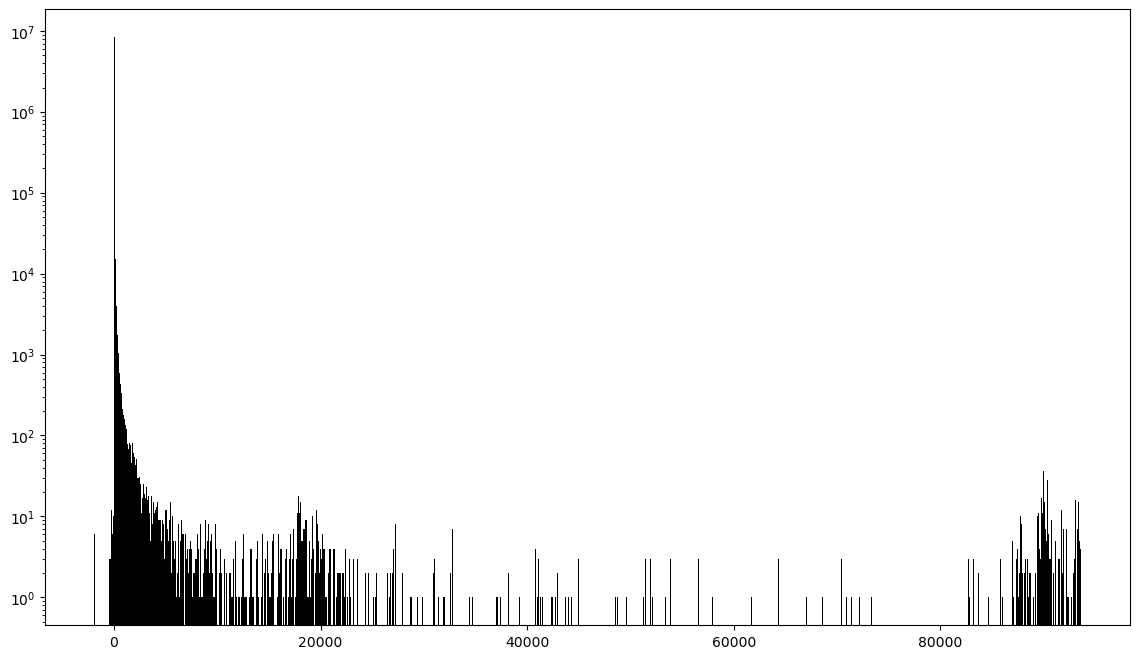

In [4]:
plt.figure(figsize=(14,8))
plt.hist(med5_img.reshape(-1), bins=1000, color='black',log='True')
plt.show()

In [5]:
med3_img.mean(),med5_img.mean(),med5_img.mean()

(61.722034, 59.132233, 59.132233)

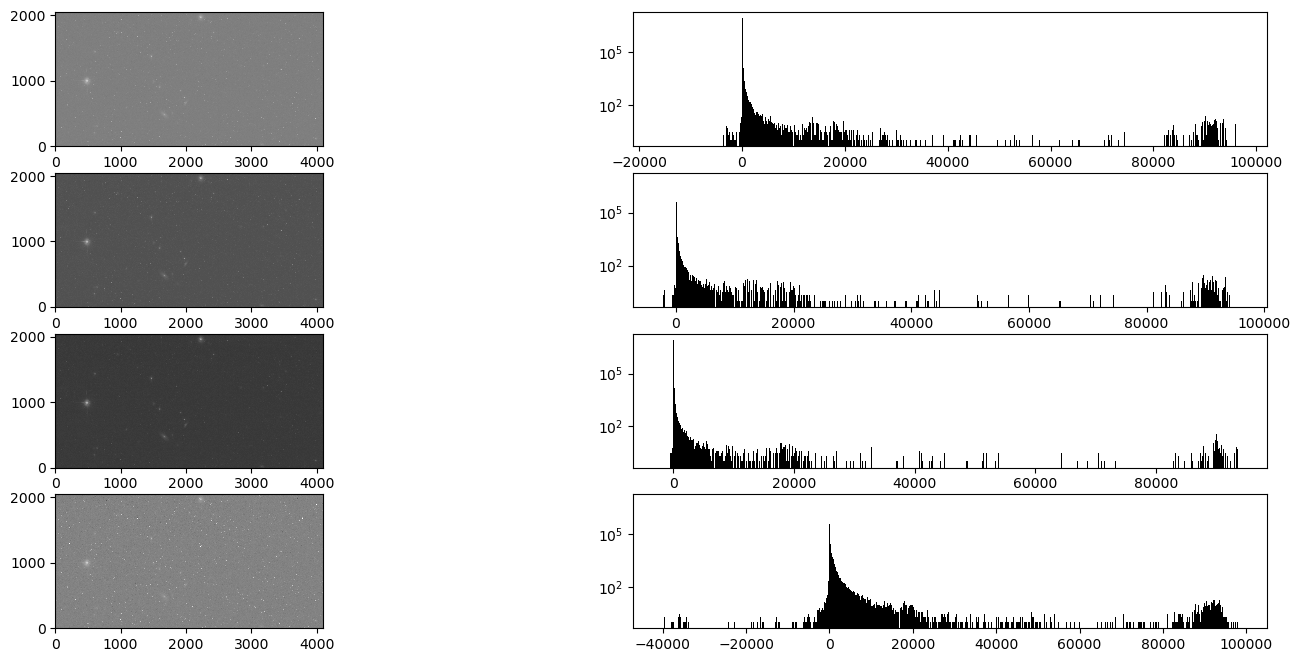

In [6]:
fig, axs = plt.subplots(4, 2, figsize=(18,8))
axs[0,0].imshow(med3_img, origin='lower', interpolation='none', cmap=plt.cm.gray,norm=LogNorm())
axs[1,0].imshow(med4_img, origin='lower', interpolation='none', cmap=plt.cm.gray,norm=LogNorm())
axs[2,0].imshow(med5_img, origin='lower', interpolation='none', cmap=plt.cm.gray,norm=LogNorm())
axs[3,0].imshow(img, origin='lower', interpolation='none', cmap=plt.cm.gray,norm=LogNorm())

axs[0,1].hist(med3_img.reshape(-1), bins=1000, color='black',log='True')
axs[1,1].hist(med4_img.reshape(-1), bins=1000, color='black',log='True')
axs[2,1].hist(med5_img.reshape(-1), bins=1000, color='black',log='True')
axs[3,1].hist(img.reshape(-1), bins=1000, color='black',log='True')
plt.show()

## 3.2 中值滤波——迭代裁剪

In [49]:
from ccdproc import Combiner
from astropy.nddata import CCDData
combiner = Combiner(CCDData(img, unit='adu'))
combiner.sigma_clipping(func=np.ma.median)
old_n_masked = 0  # dummy value to make loop execute at least once
new_n_masked = combiner.data_arr.mask.sum()
while (new_n_masked > old_n_masked):
    combiner.sigma_clipping(func=np.ma.median)
    old_n_masked = new_n_masked
    new_n_masked = combiner.data_arr.mask.sum()
mask = combiner.data_arr.mask
mask  = mask + 0


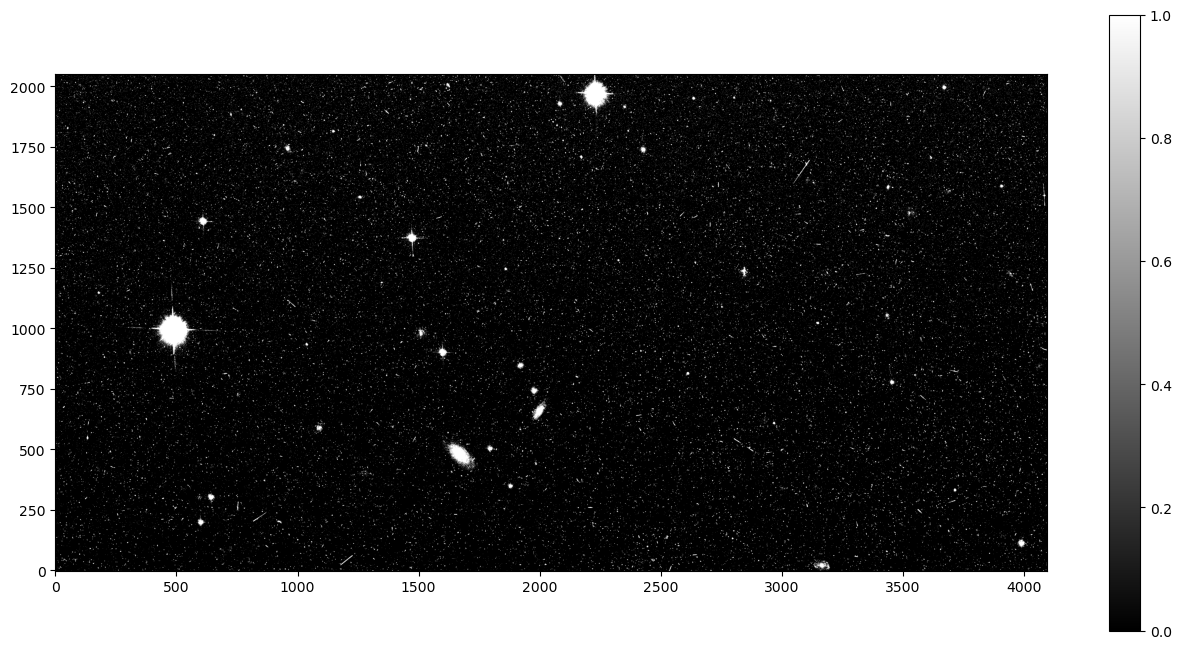

In [50]:
plt.figure(figsize=(16,8))
plt.imshow(mask,cmap=plt.cm.gray,origin='lower')
plt.colorbar()
plt.show()

## 4.找到最适宜的中值作为阈值,将图片转为二值图

In [7]:
thresh = med5_img.mean()
binary = med5_img > thresh
img1 = med5_img.copy()

img1[np.where(img > thresh)] = 1
img1[np.where(img <= thresh)] = 0


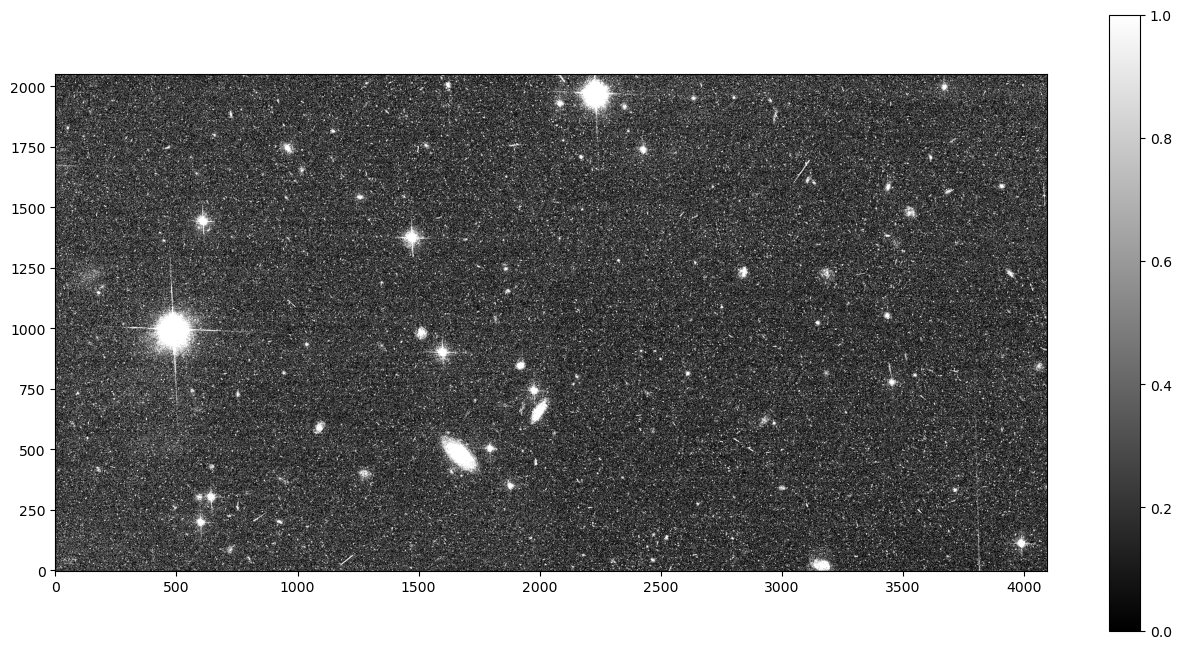

In [51]:
plt.figure(figsize=(16,8))
plt.imshow(img1, cmap=plt.cm.gray, origin='lower')
plt.colorbar()
plt.show()

## 5.1 图像进行形态学处理——开运算（先腐蚀后膨胀）
* 3.2效果更好，使用3.2的迭代裁剪

In [52]:
from skimage.morphology import disk ,opening # noqa

footprint1 = disk(3)
img_opened1 = opening(mask, footprint1)

footprint2 = disk(6)
img_opened2 = opening(mask, footprint2)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 10))
ax1.imshow(img_opened1, cmap=plt.cm.gray,origin='lower')
ax1.set_title('disk(3)')
ax1.axis('off')
ax2.imshow(img_opened2, cmap=plt.cm.gray,origin='lower')
ax2.set_title('disk(6)')
ax2.axis('off')

(-0.5, 4095.5, -0.5, 2047.5)

## 5.2 lacosmic 技术：通过基于拉普拉斯边缘检测的变体识别像素来识别宇宙射线

In [68]:
cr_cleaned = ccdproc.cosmicray_lacosmic(img, sigclip=5)
plt.figure(figsize=(16,8))
plt.imshow(cr_cleaned[0], cmap='gray', norm=LogNorm(),origin='lower')
plt.colorbar()
plt.show()

## 6.计算得到新的图像，并更新fits文件
* 通过对比分析，5.2的lacosmic 技术未能很好的去除宇宙射线
* 采用形态学方法更加合适

In [56]:
img_opened1 
image = img_opened1 * img
plt.figure(figsize=(16,8))
plt.imshow(image.astype('float32')+1, cmap='gray', norm=LogNorm(),origin='lower')
#plt.imshow(image, cmap='gray', norm=LogNorm(),origin='lower')
#plt.imshow(img - image, cmap='gray', norm=LogNorm(),origin='lower')
plt.colorbar()
plt.show()

In [13]:
gals[1].data = image
gals.writeto('new_jbit11e1q_flc.fits', overwrite = True)
gals.close()